In [1]:
import strawberryfields as sf

In [2]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
prog = sf.Program(1)

In [4]:
with prog.context as q:
    Vac | q[0]

eng = sf.Engine('gaussian')
state = eng.run(prog).state

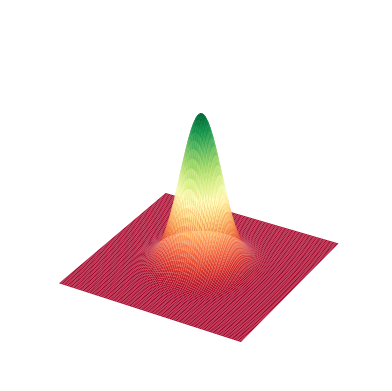

In [5]:
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

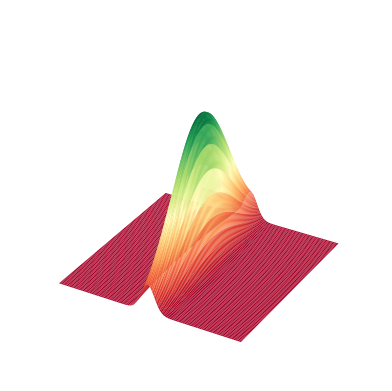

In [6]:
prog = sf.Program(1)
with prog.context as q:
    S = Sgate(1)
    S | q[0]


state = eng.run(prog).state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
fig.set_size_inches(4.8, 5)
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.set_axis_off()

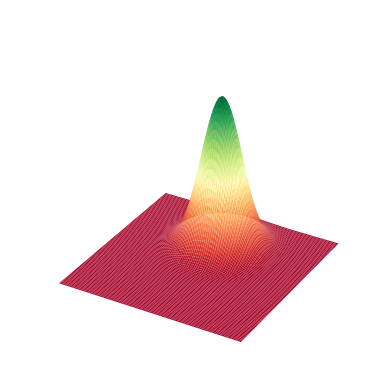

In [7]:
prog = sf.Program(1)
with prog.context as q:
    Dgate(1) | q[0]
    Rgate(np.pi/2) | q[0]

eng.reset()
state = eng.run(prog).state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

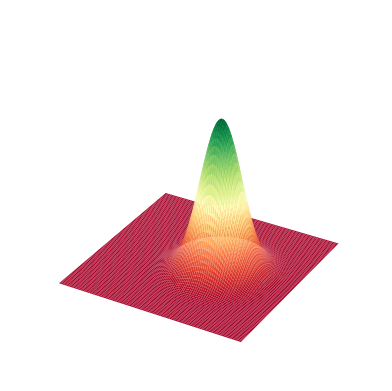

In [8]:
prog = sf.Program(1)
with prog.context as q:
    Dgate(0.55) | q[0]

eng.reset()
state = eng.run(prog).state
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

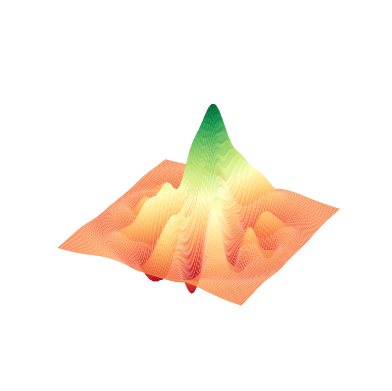

In [9]:
prog = sf.Program(1)
with prog.context as q:
    gamma = 2
    Vgate(gamma) | q[0]

#We use the fock backend and define the argument cutoff_dim
eng = sf.Engine('fock', backend_options={"cutoff_dim": 10})
state = eng.run(prog).state

fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

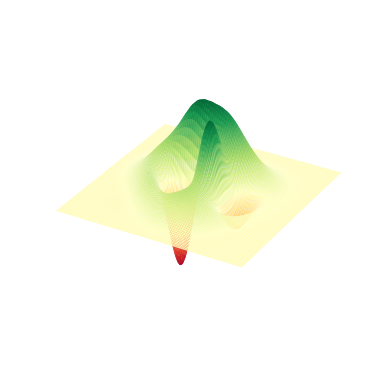

In [10]:
prog = sf.Program(1)
with prog.context as q:
    kappa = 1
    Dgate(1) | q[0]
    Kgate(kappa) | q[0]

eng.reset()
state = eng.run(prog).state

fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

In [11]:
from strawberryfields.apps import sample
import numpy as np

modes = 5
n_mean = 6
samples = 5

A = np.random.normal(0, 1, (modes, modes))
A = A + A.T

s_thresh = sample.sample(A, n_mean, samples, threshold=True)
s_pnr = sample.sample(A, n_mean, samples, threshold=False)

print(s_thresh)
print(s_pnr)

/Users/matthieu.sarkis/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
/Users/matthieu.sarkis/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
/Users/matthieu.sarkis/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/thewalrus/samples.py:367: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/matthieu.sarkis/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/thewalrus/samples.py:370: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/matthieu.sarkis/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
/Users/matthieu.sarkis/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 1, 1, 0], [1, 0, 0, 1, 1], [1, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2, 0, 2, 0, 0], [3, 0, 1, 0, 0], [0, 0, 2, 0, 2]]


/Users/matthieu.sarkis/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
/Users/matthieu.sarkis/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
